In [1]:
# Parameters 

provider = 'CDS'
GCM = 'CMCC'

In [2]:
%matplotlib inline

In [3]:
import os
import sys 
import pathlib

In [4]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [5]:
HOME = pathlib.Path.home()

In [6]:
sys.path.append('../../../utils/')

In [7]:
from set_root_dir import set_root_dir
from get_GCM_outputs import get_GCM_outputs
from shift_dset_time import shift_dset_time 

In [8]:
from matplotlib import pyplot as plt

In [9]:
import proplot as plot

In [10]:
import numpy as np
import pandas as pd

In [11]:
import xarray as xr

In [12]:
xr.__version__

'0.15.1'

In [13]:
%%writefile ../../../utils/get_GCM_outputs.py
def get_GCM_outputs(provider='CDS', GCM='ECMWF', var_name='T2M', period='hindcasts', rpath=None, domain=[90, 300, -65, 50], step=None, verbose=False, flatten=True, nmembers=None):
    
    """
    Get the GCM outputs 
    
    Parameters
    ----------
    
    - provider: in ['CDS','IRI','JMA'] 
    - GCM: name of the GCM 
    - var_name: in ['T2M', 'PRECIP']
    - period: in ['hindcasts', 'forecasts']
    - rpath (root path, pathlib.Path object, see `set_root_dir` in the utils module)
    - domain [lon_min, lon_max, lat_min, lat_max]
    - step ( in [3, 4, 5] )
    - verbose: Boolean, whether to print names of files successfully opened
    - flatten: Boolean, whether of not to stack the dataset over the spatial (+ member if present) dimension
    to get 2D fields
    
    Return
    ------ 
    
    - dset: xarray.Dataset concatenated along the time dimension 

    """
    
    
    import pathlib
    import xarray as xr
    
    ipath = rpath /  'GCMs'/ 'processed' / period / provider / GCM / var_name
    
    lfiles_gcm = list(ipath.glob(f"{GCM}_{var_name}_seasonal_anomalies_interp_????_??.nc"))
    
    if (period == 'hindcasts') and (len(lfiles_gcm) ) < 200: 
        print(f"Something wrong with the number of files in the list for the {period} period, the length is {len(lfiles_gcm)}")
    if (period == 'forecasts') and (len(lfiles_gcm) ) < 20:
        print(f"Something wrong with the number of files in the list for the {period} period, the length is {len(lfiles_gcm)}")
    
    lfiles_gcm.sort()
    
    print(f"first file is {str(lfiles_gcm[0])}")
    print(f"last file is {str(lfiles_gcm[-1])}")

    dset_l = []
    
    for fname in lfiles_gcm: 
        
        dset = xr.open_dataset(fname)[[var_name.lower()]]
        
        if 'surface' in dset.dims: 
            dset = dset.drop('surface')
        
        # select the domain 
        
        if domain is not None: 
            dset = dset.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3]))
        if step is not None: 
            dset = dset.sel(step=step)
         
                
        if verbose: 
            print(f"successfully opened and extracted {fname}")
    
        dset_l.append(dset)

    dset = xr.concat(dset_l, dim='time', coords='minimal', compat='override')
    
    # now get the coordinates, will be returned along with the dataset itself, 
    # regarding of whether the dataset is flattened 
    
    #dims_tuple = (dset.dims, dset[var_name.lower()].dims) 
    
    if nmembers is not None: 
        
        dset = dset.isel(member=slice(0, nmembers))

    coords = dset.coords
    
    if flatten: 
        
        if 'member' in dset.dims: 
            
            dset = dset.stack(z=('member','lat','lon'))
        
        else: 
            
            dset = dset.stack(z=('lat','lon'))    
    
    return dset, coords


Overwriting ../../../utils/get_GCM_outputs.py


In [14]:
rpath = set_root_dir(root='gdata')

In [15]:
rpath

PosixPath('/media/nicolasf/GDATA/END19101/Working/data')

In [66]:
dset_t2m_ecmwf_hindcasts, coords_hindcasts = get_GCM_outputs(provider=provider, \
                                                             GCM=GCM, var_name='T2M', period='hindcasts', rpath=rpath, domain=[90, 300, -65, 50], step=3, flatten=False)

first file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/CMCC/T2M/CMCC_T2M_seasonal_anomalies_interp_1993_01.nc
last file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/CMCC/T2M/CMCC_T2M_seasonal_anomalies_interp_2016_12.nc


In [67]:
dset_t2m_ecmwf_hindcasts

<xarray.Dataset>
Dimensions:  (lat: 47, lon: 85, member: 40, time: 264)
Coordinates:
    month    int64 ...
    step     int64 3
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
  * lon      (lon) float64 90.0 92.5 95.0 97.5 100.0 ... 292.5 295.0 297.5 300.0
  * lat      (lat) float64 -65.0 -62.5 -60.0 -57.5 -55.0 ... 42.5 45.0 47.5 50.0
  * time     (time) datetime64[ns] 1993-01-01 1993-03-01 ... 2016-12-01
Data variables:
    t2m      (time, member, lat, lon) float64 1.209 0.9905 ... 0.895 0.1982
Attributes:
    regrid_method:  bilinear

In [68]:
dset_t2m_ecmwf_hindcasts.dims

Frozen(SortedKeysDict({'member': 40, 'lon': 85, 'lat': 47, 'time': 264}))

### get the dimensions IN ORDER for the variable of interest in a tuple

In [69]:
dset_precip_ecmwf_hindcasts, coords_hindcasts = get_GCM_outputs(provider=provider, \
                                                                GCM=GCM, var_name='PRECIP', period='hindcasts', rpath=rpath, domain=[90, 300, -65, 50], step=3, flatten=False)

first file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/CMCC/PRECIP/CMCC_PRECIP_seasonal_anomalies_interp_1993_01.nc
last file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/CDS/CMCC/PRECIP/CMCC_PRECIP_seasonal_anomalies_interp_2016_12.nc


In [70]:
dset_precip_ecmwf_hindcasts

<xarray.Dataset>
Dimensions:  (lat: 47, lon: 85, member: 40, time: 288)
Coordinates:
    month    int64 ...
    step     int64 3
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
  * lon      (lon) float64 90.0 92.5 95.0 97.5 100.0 ... 292.5 295.0 297.5 300.0
  * lat      (lat) float64 -65.0 -62.5 -60.0 -57.5 -55.0 ... 42.5 45.0 47.5 50.0
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
Data variables:
    precip   (time, member, lat, lon) float64 4.07e-09 3.327e-09 ... -5.247e-09
Attributes:
    regrid_method:  bilinear

In [71]:
dset_precip_ecmwf_hindcasts.dims

Frozen(SortedKeysDict({'member': 40, 'lon': 85, 'lat': 47, 'time': 288}))

In [72]:
if 'valid_time' in dset_precip_ecmwf_hindcasts.coords: 
    dset_precip_ecmwf_hindcasts = dset_precip_ecmwf_hindcasts.drop('valid_time')

In [73]:
if 'valid_time' in dset_t2m_ecmwf_hindcasts.coords: 
    dset_t2m_ecmwf_hindcasts = dset_t2m_ecmwf_hindcasts.drop('valid_time')

### Now get the forecasts datasets (test period)

In [79]:
dset_t2m_ecmwf_forecasts, coords_forecasts = get_GCM_outputs(provider=provider, \
                                                             GCM=GCM, var_name='T2M', period='forecasts', rpath=rpath, domain=[90, 300, -65, 50], step=3, flatten=False)

Something wrong with the number of files in the list for the forecasts period, the length is 14
first file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/forecasts/CDS/CMCC/T2M/CMCC_T2M_seasonal_anomalies_interp_2018_11.nc
last file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/forecasts/CDS/CMCC/T2M/CMCC_T2M_seasonal_anomalies_interp_2019_12.nc


<xarray.Dataset>
Dimensions:  (lat: 47, lon: 85, member: 40, month: 10, time: 14)
Coordinates:
    step     int64 3
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
  * lon      (lon) float64 90.0 92.5 95.0 97.5 100.0 ... 292.5 295.0 297.5 300.0
  * lat      (lat) float64 -65.0 -62.5 -60.0 -57.5 -55.0 ... 42.5 45.0 47.5 50.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10
  * time     (time) datetime64[ns] 2018-11-01 2018-12-01 ... 2019-12-01
Data variables:
    t2m      (time, member, lat, lon, month) float64 -0.2466 -0.2466 ... 1.567

In [23]:
dset_t2m_ecmwf_forecasts.dims

Frozen(SortedKeysDict({'month': 10, 'time': 14, 'z': 159800}))

In [24]:
dset_precip_ecmwf_forecasts, coords_forecasts = get_GCM_outputs(provider=provider, \
                                                                GCM=GCM, var_name='PRECIP', period='forecasts', rpath=rpath, domain=[90, 300, -65, 50], step=3, flatten=True)

Something wrong with the number of files in the list for the forecasts period, the length is 14
first file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/forecasts/CDS/CMCC/PRECIP/CMCC_PRECIP_seasonal_anomalies_interp_2018_11.nc
last file is /media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/forecasts/CDS/CMCC/PRECIP/CMCC_PRECIP_seasonal_anomalies_interp_2019_12.nc


### now shifts the time index so that the time corresponds to the time of the forecast, not the initialisation time 

### also shifts to the end of the month, to correspond to the convention used in the target time-series 

In [25]:
step = 3

In [26]:
dset_t2m_ecmwf_hindcasts = shift_dset_time(dset_t2m_ecmwf_hindcasts)

In [27]:
dset_precip_ecmwf_hindcasts = shift_dset_time(dset_precip_ecmwf_hindcasts)

In [28]:
dset_t2m_ecmwf_forecasts = shift_dset_time(dset_t2m_ecmwf_forecasts)

In [29]:
dset_precip_ecmwf_forecasts = shift_dset_time(dset_precip_ecmwf_forecasts)

In [30]:
dset_precip_ecmwf_forecasts

<xarray.Dataset>
Dimensions:  (month: 10, time: 14, z: 199750)
Coordinates:
    step     int64 3
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10
  * time     (time) datetime64[ns] 2019-02-28 2019-03-31 ... 2020-03-31
  * z        (z) MultiIndex
  - member   (z) int64 0 0 0 0 0 0 0 0 0 0 0 ... 49 49 49 49 49 49 49 49 49 49
  - lat      (z) float64 -65.0 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon      (z) float64 90.0 92.5 95.0 97.5 100.0 ... 292.5 295.0 297.5 300.0
Data variables:
    precip   (time, month, z) float64 5.198e-09 4.646e-09 ... -1.461e-08

In [31]:
dset_precip_ecmwf_forecasts

<xarray.Dataset>
Dimensions:  (month: 10, time: 14, z: 199750)
Coordinates:
    step     int64 3
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10
  * time     (time) datetime64[ns] 2019-02-28 2019-03-31 ... 2020-03-31
  * z        (z) MultiIndex
  - member   (z) int64 0 0 0 0 0 0 0 0 0 0 0 ... 49 49 49 49 49 49 49 49 49 49
  - lat      (z) float64 -65.0 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon      (z) float64 90.0 92.5 95.0 97.5 100.0 ... 292.5 295.0 297.5 300.0
Data variables:
    precip   (time, month, z) float64 5.198e-09 4.646e-09 ... -1.461e-08

### scikit learn imports 

### scaler 

In [32]:
from sklearn.preprocessing import StandardScaler

### PCA 

In [33]:
from sklearn.decomposition import kernel_pca, pca
from eofs.xarray import Eof

### creates the weights now 

In [34]:
coslat = np.cos(np.deg2rad(dset_t2m_ecmwf_forecasts.coords['lat'].data))
wgts = np.sqrt(coslat)[..., np.newaxis]

In [35]:
wgts.shape

(159800, 1)

### pipeline 

In [36]:
from sklearn.pipeline import make_pipeline

--- 
---
---

### TARGETS 

In [37]:
dpath_target = HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'targets' / 'NZ_regions' / 'NZ_6_regions'

#### RAINFALL 

In [38]:
target_var = 'TMEAN'

In [39]:
targets = []
for region_name in ['NNI','WNI','ENI','NSI','WSI','ESI']: 
    target = pd.read_csv(dpath_target / target_var / region_name / f'TS_NZ_region_{region_name}_{target_var}_3_quantiles_anoms.csv', index_col=0, parse_dates=True)
    target.columns = pd.MultiIndex.from_product([[region_name],target.columns])
    targets.append(target)

In [40]:
targets = pd.concat(targets, axis=1)

In [41]:
targets.head()

NNI                        WNI                        ENI  \
              Tmean_N cat_3 anomalies    Tmean_N cat_3 anomalies    Tmean_N   
time                                                                          
1979-03-31  18.278555     3  0.462528  16.051472     3  0.317965  16.732249   
1979-04-30  16.794408     2  0.227319  14.586906     3  0.248038  14.953599   
1979-05-31  14.695903     2  0.282907  12.522320     3  0.425773  12.716266   
1979-06-30  12.093823     2 -0.001099   9.888909     2  0.117671   9.929897   
1979-07-31  10.290536     2 -0.061355   8.182231     2  0.120974   8.208954   

                                  NSI                        WSI        \
           cat_3 anomalies    Tmean_N cat_3 anomalies    Tmean_N cat_3   
time                                                                     
1979-03-31     3  0.621540  13.811438     2 -0.093327  11.848419     1   
1979-04-30     3  0.299057  12.189450     1 -0.249176  10.589580     2   
1979-05-31     2  0.314655   9.888897     1 -0.215657   8.099501     1   
1979-06-30     1 -0.065854   7.198980     1 -0.300772   5.457298     1   
1979-07-31     2 -0.063564   5.534868     2 -0.058724   3.763353     2   

                            ESI                  
           anomalies    Tmean_N cat_3 anomalies  
time                                             
1979-03-31 -0.400334  13.728706     2 -0.222255  
1979-04-30 -0.110858  12.033578     2 -0.208919  
1979-05-31 -0.202497   9.232035     1 -0.470303  
1979-06-30 -0.197458   6.634168     1 -0.254247  
1979-07-31  0.085515   4.916423     2  0.112719

In [42]:
targets_anomalies = targets.loc[:, (slice(None), ["anomalies"])]

In [43]:
target_terciles = targets.loc[:, (slice(None), ["cat_3"])]

In [44]:
targets_anomalies.columns = targets_anomalies.columns.droplevel(1)

In [45]:
targets_anomalies.corr()

,NNI,WNI,ENI,NSI,WSI,ESI
NNI,1.000000,0.970509,0.929788,0.891544,0.787952,0.807058
WNI,0.970509,1.000000,0.935192,0.922933,0.843518,0.856946
ENI,0.929788,0.935192,1.000000,0.854135,0.727656,0.822796
NSI,0.891544,0.922933,0.854135,1.000000,0.922623,0.901411
WSI,0.787952,0.843518,0.727656,0.922623,1.000000,0.906402
ESI,0.807058,0.856946,0.822796,0.901411,0.906402,1.000000


In [46]:
target_terciles.columns = target_terciles.columns.droplevel(1)

In [47]:
target_terciles.corr()

,NNI,WNI,ENI,NSI,WSI,ESI
NNI,1.000000,0.892095,0.829419,0.810607,0.682188,0.719554
WNI,0.892095,1.000000,0.841664,0.809888,0.701791,0.757966
ENI,0.829419,0.841664,1.000000,0.760275,0.634579,0.723682
NSI,0.810607,0.809888,0.760275,1.000000,0.811111,0.803168
WSI,0.682188,0.701791,0.634579,0.811111,1.000000,0.814691
ESI,0.719554,0.757966,0.723682,0.803168,0.814691,1.000000


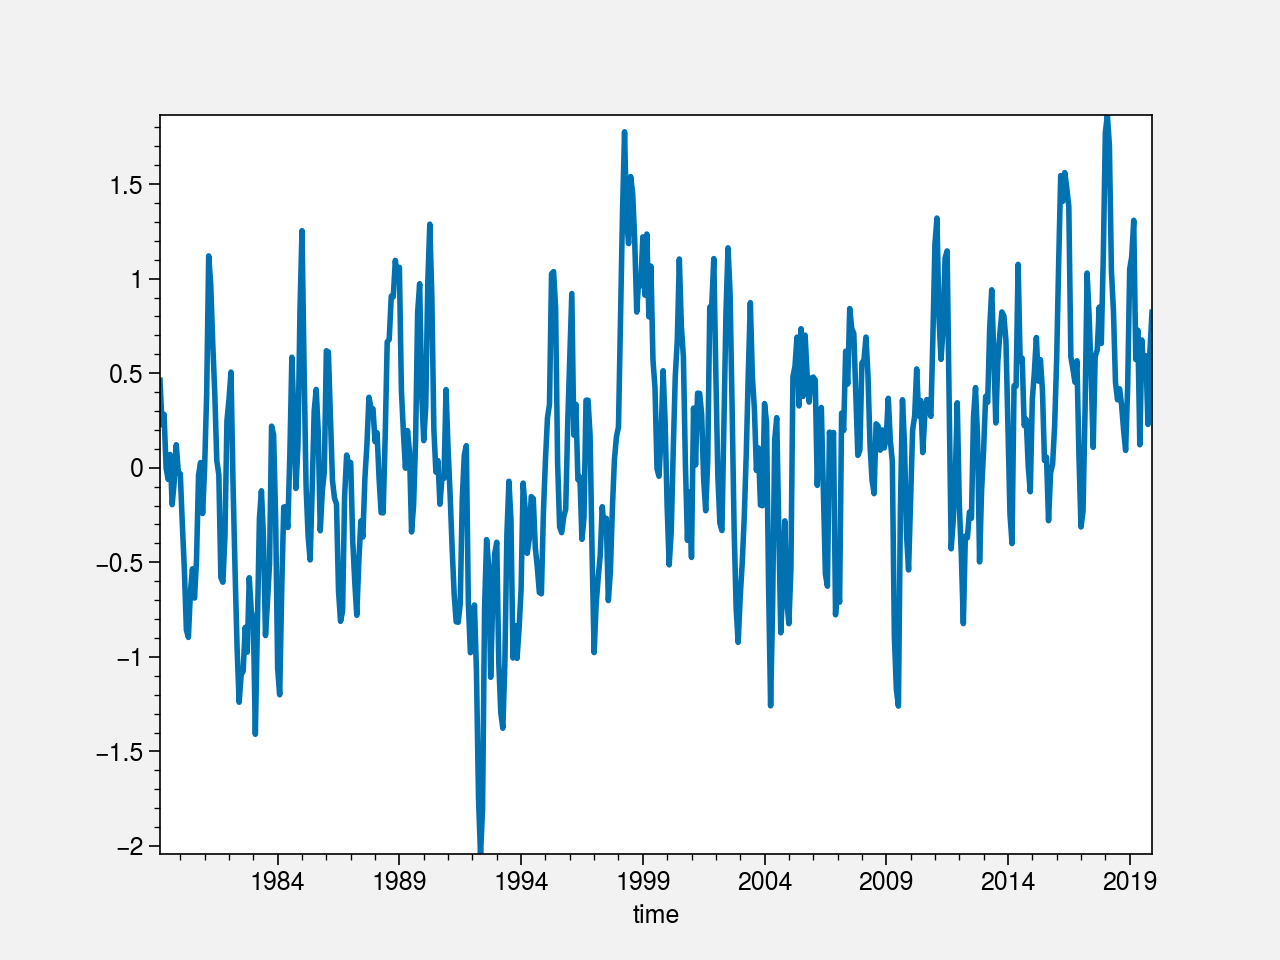

In [48]:
f, ax = plt.subplots()
targets_anomalies.NNI.plot(ax=ax, lw=2)
ax.grid(ls=':', color='w')

### reduce the dimensionality of the hindcasts / forecasts using PCA 

### Get the data in a numpy array 

#### loads in case the underlying data structures are dask arrays 

In [49]:
dset_t2m_ecmwf_hindcasts.load()

<xarray.Dataset>
Dimensions:  (time: 264, z: 159800)
Coordinates:
    month    int64 1
    step     int64 3
  * time     (time) datetime64[ns] 1993-04-30 1993-06-30 ... 2017-03-31
  * z        (z) MultiIndex
  - member   (z) int64 0 0 0 0 0 0 0 0 0 0 0 ... 39 39 39 39 39 39 39 39 39 39
  - lat      (z) float64 -65.0 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon      (z) float64 90.0 92.5 95.0 97.5 100.0 ... 292.5 295.0 297.5 300.0
Data variables:
    t2m      (time, z) float64 1.209 0.9905 0.823 0.8165 ... 1.36 0.895 0.1982
Attributes:
    regrid_method:  bilinear

In [50]:
X_t2m_train = dset_t2m_ecmwf_hindcasts['t2m'].data

### initialise the standard scaler 

In [51]:
scaler_t2m = StandardScaler()

### fit and transform 

In [52]:
X_t2m_train = scaler_t2m.fit_transform(X_t2m_train)

### verify that mean ~= 0 and std ~= 1 for all features (grid points)

In [53]:
X_t2m_train.mean(0)

array([ 1.85352575e-16, -4.75209098e-17, -2.59262309e-16, ...,
       -1.68215610e-18,  2.39707244e-17, -1.24059012e-17])

In [54]:
X_t2m_train.std(0)

array([1., 1., 1., ..., 1., 1., 1.])

### initialise the PCA, 

#### percentage of variance we want to keep, scikit - learn will automatically select the number of PCs 

In [55]:
percent_variance = 0.8

#### initialisation 

In [56]:
skpca_t2m = pca.PCA(n_components=percent_variance)

#### fit AND transform, returns the PCs 

In [57]:
skpca_t2m_PCs_train = skpca_t2m.fit_transform(X_t2m_train)

### shape, number of pcs, do not forget that the 'member' dimension is also included in the z stacked dimension (member, lat, lon)

In [58]:
skpca_t2m_PCs_train.shape

(264, 128)

In [59]:
n_pcs = skpca_t2m_PCs_train.shape[1]

In [60]:
print(n_pcs)

128


### gets the EOFs 

In [61]:
eofs_t2m_train = skpca_t2m.components_

In [62]:
eofs_t2m_train.shape

(128, 159800)

### reshape

In [63]:
dset_t2m_ecmwf_hindcasts.coords['z']

<xarray.DataArray 'z' (z: 159800)>
array([(0, -65.0, 90.0), (0, -65.0, 92.5), (0, -65.0, 95.0), ...,
       (39, 50.0, 295.0), (39, 50.0, 297.5), (39, 50.0, 300.0)], dtype=object)
Coordinates:
    month    int64 1
    step     int64 3
  * z        (z) MultiIndex
  - member   (z) int64 0 0 0 0 0 0 0 0 0 0 0 ... 39 39 39 39 39 39 39 39 39 39
  - lat      (z) float64 -65.0 -65.0 -65.0 -65.0 -65.0 ... 50.0 50.0 50.0 50.0
  - lon      (z) float64 90.0 92.5 95.0 97.5 100.0 ... 292.5 295.0 297.5 300.0

### Now calculate (project) the corresponding PCs in the forecast period

#### prior to that, transform using the Standard Scaler fitted over the hindcast period  

In [64]:
X_t2m_test =  dset_t2m_ecmwf_forecasts['t2m'].data

In [65]:
X_t2m_test = scaler_t2m.transform(X_t2m_test)

ValueError: Found array with dim 3. StandardScaler expected <= 2.

#### checks that the mean and the std are not too far off 0 and 1 respectively, note that due to temperarture trends, we expect an increase in the mean 

In [ ]:
X_t2m_test.mean()

In [ ]:
X_t2m_test.std()

#### now transforms using the pca object fitted previously on the training data 

In [ ]:
skpca_t2m_PCs_test = skpca_t2m.transform(X_t2m_test)

### plots the PCs, casts these into a dataframe, with the correct time index 

In [ ]:
df_skpca_t2m_PCs_train = pd.DataFrame(skpca_t2m_PCs_train, index=dset_t2m_ecmwf_hindcasts['time'].to_index())

In [ ]:
df_skpca_t2m_PCs_test = pd.DataFrame(skpca_t2m_PCs_test, index=dset_t2m_ecmwf_forecasts['time'].to_index())

In [ ]:
df_skpca_t2m_PCs_train.loc[:,0:10].plot(legend=None); 

In [ ]:
df_skpca_t2m_PCs_test.loc[:,0:10].plot(legend=None); 

In [ ]:
eofs_t2m_train.shape

In [ ]:
coords_hindcasts.dims

In [ ]:
eofs_t2m_train = eofs_t2m_train.reshape((n_pcs, coords_hindcasts.dims['member'], coords_hindcasts.dims['lat'], coords_hindcasts.dims['lon']))

In [ ]:
eofs_t2m_train.shape

### put this into a dataset with the right dimensions

In [ ]:
d = {}
d['pc'] = (('pc'), np.arange(n_pcs))
d['member'] = coords_hindcasts['member']
d['lat'] = coords_hindcasts['lat']
d['lon'] = coords_hindcasts['lon'] 
d['eof'] = (('pc','member','lat','lon'), eofs_t2m_train)

In [ ]:
eofs_train_dset = xr.Dataset(d)

### plots all the EOFs along the member dimension 

In [ ]:
eofs_train_dset.sel(pc=6)['eof'].plot(x='lon',y='lat', col='member', col_wrap=5, add_colorbar=False)

### Principal component associated with the first EOF 

In [ ]:
df_skpca_t2m_PCs_train.loc[:,6].plot()

In [ ]:
target_terciles

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [ ]:
from sklearn import metrics

In [ ]:
acc_score = {}
f1_score  = {}


for region_name in ['NNI','WNI','ENI','NSI','WSI','ESI']: 
    
    train = df_skpca_t2m_PCs_train.copy()
    train = train.merge(target_terciles.loc[:,region_name], left_index=True, right_index=True)
    
    test = df_skpca_t2m_PCs_test.copy()
    test = test.merge(target_terciles.loc[:,region_name], left_index=True, right_index=True)
    
    X_train = train.iloc[:,:-1].values
    y_train = train.iloc[:,-1].values
    
    X_test = test.iloc[:,:-1].values
    y_test = test.iloc[:,-1].values
    
    knn = KNN(n_neighbors=5, metric='minkowski', weights='distance', p=1)
    
    knn.fit(X_train, y_train)
    
    acc_score[region_name] = knn.score(X_test, y_test)
    
    y_test_pred_prob = knn.predict_proba(X_test)
    
    y_test_pred = knn.predict(X_test)
    
    f1_score[region_name] = metrics.f1_score(y_test, y_test_pred, average=None)

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
acc_score_dict = {}

for region_name in ['NNI','WNI','ENI','NSI','WSI','ESI']: 
    
    train = df_skpca_t2m_PCs_train.copy()
    train = train.merge(target_terciles.loc[:,region_name], left_index=True, right_index=True)

    test = df_skpca_t2m_PCs_test.copy()
    test = test.merge(target_terciles.loc[:,region_name], left_index=True, right_index=True)

    X_train = train.iloc[:,:-1].values
    y_train = train.iloc[:,-1].values

    X_test = test.iloc[:,:-1].values
    y_test = test.iloc[:,-1].values
    
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    
    skf.get_n_splits(X, y)
    
    acc_score = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        knn = KNN(n_neighbors=1, metric='minkowski', weights='distance', p=3)

        knn.fit(X_train, y_train)

        acc_score.append(knn.score(X_test, y_test))
    
    acc_score_dict[region_name] = np.array(acc_score) 
    

In [ ]:
acc_score_df = pd.DataFrame(acc_score_dict)

In [ ]:
acc_score_df.describe().loc[['min','mean','max']]